# Exploratory Data Analysis

### Imports

In [1]:
from pandas_profiling import ProfileReport
import pandas as pd
import numpy as np
from modeling import *
import plotly.express as px

### Parameters

In [2]:
target_col = "price"

## Load train dataset

In [175]:
df_train = pd.read_feather("../data/processed/train.feather")
print(df_train.shape)

(72241, 49)


## Additional processing

To understand how geohash delimiter it's better to final model, we'll generate features for each geohash delimiter.

See more about geohash in **docs/geohash.md**

In [176]:
geohashs_delimiters = [3, 4, 5, 6]

for i in geohashs_delimiters:
    key = "geohash_{}".format(i)
    df_train[key] = [str(g)[:i] for g in df_train["geohash"]]

In [177]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72241 entries, 0 to 72240
Data columns (total 53 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             72241 non-null  object 
 1   usableAreas                    72231 non-null  float64
 2   parkingSpaces                  71019 non-null  float64
 3   suites                         66274 non-null  float64
 4   bathrooms                      72240 non-null  float64
 5   totalAreas                     43864 non-null  float64
 6   bedrooms                       72241 non-null  int64  
 7   publicationType                72241 non-null  object 
 8   geohash                        72231 non-null  object 
 9   price                          72241 non-null  int64  
 10  businessType                   72241 non-null  object 
 11  yearlyIptu                     62236 non-null  float64
 12  monthlyCondoFee                68461 non-null 

In [178]:
fig = px.histogram(df_train, x=target_col, nbins=50, color="businessType", title="Distribution of businessType")
fig.show()

In [181]:
# prepare dataset for EDA

# filter only SALE
df_eda = df_train[df_train["businessType"] == "SALE"].copy()
print(df_eda.shape)      

# GROUP ALL OUTLIERS OUT 5M
df_eda[target_col] = [e if e <= 5000000 else 5000000 for e in df_eda[target_col].tolist()]

# GROUP ALL OUTLIERS LESS THAN 100K
df_eda[target_col] = [100000 if e <= 100000 else e for e in df_eda[target_col].tolist()]

(64146, 53)


In [184]:
fig = px.histogram(df_eda, x=target_col, nbins=50, color="has_pool", title="Distribution of has_pool")
fig.show()

## Porcentagens de ricos no bairro

Usando os dados do IBGE, vamos calcular a porcentagem de ricos no bairro.

In [185]:
lower_salary = ["renda_nom_dom_sal_baixo1", "renda_nom_dom_sal_baixo2",
                "renda_nom_dom_sal_baixo3", "renda_nom_dom_sal_baixo4",
               "renda_nom_dom_sal_medio1", "renda_nom_dom_sal_medio2",
               "renda_nom_dom_sal_medio3"]

higher_salary = ["renda_nom_dom_sal_alto1", "renda_nom_dom_sal_alto2"]

all_salary = lower_salary + higher_salary

def sum_columns(df, columns):
    result = np.zeros(len(df))
    for col in columns:
        result = result + df[col].values
    return result

df_eda["wealthy_salary_count"] = sum_columns(df_eda, higher_salary)
df_eda["wealthy_salary_rate"] = df_eda["wealthy_salary_count"] / sum_columns(df_eda, all_salary)
#df_eda["wealthy_rate_neighborhood"] = [False if e <= 0.5 else True for e in df_eda["wealthy_salary_rate"].tolist()]
df_eda["wealthy_rate_neighborhood"] = pd.qcut(df_eda['wealthy_salary_rate'], q=5)

In [186]:
new_cols = ["wealthy_salary_count", "wealthy_salary_rate", "wealthy_rate_neighborhood"]

df_eda[all_salary+new_cols]

renda_nom_dom_sal_baixo1  renda_nom_dom_sal_baixo2  \
0                           0.0                       0.0   
1                           5.0                       0.0   
2                           0.0                       0.0   
3                           2.0                       3.0   
4                           1.0                       0.0   
...                         ...                       ...   
72236                       0.0                       0.0   
72237                       0.0                       0.0   
72238                       1.0                       0.0   
72239                       1.0                       4.0   
72240                       0.0                       1.0   

       renda_nom_dom_sal_baixo3  renda_nom_dom_sal_baixo4  \
0                           1.0                       4.0   
1                           1.0                       4.0   
2                           0.0                       7.0   
3                          19.0                      58.0   
4                           4.0                      12.0   
...                         ...                       ...   
72236                       0.0                       5.0   
72237                       2.0                      15.0   
72238                       2.0                      17.0   
72239                      28.0                      79.0   
72240                       4.0                      21.0   

       renda_nom_dom_sal_medio1  renda_nom_dom_sal_medio2  \
0                          17.0                      18.0   
1                          11.0                      12.0   
2                           5.0                      14.0   
3                          73.0                      20.0   
4                           7.0                       6.0   
...                         ...                       ...   
72236                      14.0                      14.0   
72237                      36.0                      34.0   
72238                      27.0                      26.0   
72239                      85.0                      17.0   
72240                      54.0                      30.0   

       renda_nom_dom_sal_medio3  renda_nom_dom_sal_alto1  \
0                          39.0                     87.0   
1                          21.0                     81.0   
2                          26.0                     51.0   
3                          20.0                     15.0   
4                          13.0                     36.0   
...                         ...                      ...   
72236                      21.0                      6.0   
72237                      39.0                     86.0   
72238                      31.0                     23.0   
72239                       3.0                      1.0   
72240                      22.0                     13.0   

       renda_nom_dom_sal_alto2  wealthy_salary_count  wealthy_salary_rate  \
0                         83.0                 170.0             0.682731   
1                        150.0                 231.0             0.810526   
2                         43.0                  94.0             0.643836   
3                          5.0                  20.0             0.093023   
4                         36.0                  72.0             0.626087   
...                        ...                   ...                  ...   
72236                      0.0                   6.0             0.100000   
72237                     63.0                 149.0             0.541818   
72238                      3.0                  26.0             0.200000   
72239                      1.0                   2.0             0.009132   
72240                      2.0                  15.0             0.102041   

      wealthy_rate_neighborhood  
0                  (0.667, 1.0]  
1                  (0.667, 1.0]  
2                (0.474, 0.667]  
3                (-0.001, 

In [187]:
fig = px.histogram(df_eda.dropna(subset=["wealthy_rate_neighborhood"]),
                   x=target_col, nbins=50, color="wealthy_rate_neighborhood",
                   title="Distribution of wealthy_rate_neighborhood")
fig.show()

In [188]:
df_eda["usableAreas_bins"] = pd.qcut(df_eda['usableAreas'], q=4)

In [189]:
fig = px.histogram(df_eda.dropna(subset=["usableAreas_bins"]), x=target_col,
                   nbins=50, color="usableAreas_bins", title="Distribution of usableAreas")
fig.show()

## Pandas Profiling

In [202]:
# Creating features discovered in EDA

df_train["wealthy_salary_count"] = sum_columns(df_train, higher_salary)
df_train["wealthy_salary_rate"] = df_train["wealthy_salary_count"] / sum_columns(df_train, all_salary)
df_train["wealthy_rate_neighborhood"] = pd.qcut(df_train['wealthy_salary_rate'], q=5)
df_train["wealthy_rate_neighborhood"] = df_train["wealthy_rate_neighborhood"].astype(str)

df_train["usableAreas_bins"] = pd.qcut(df_eda['usableAreas'], q=4)
df_train["usableAreas_bins"] = df_train["usableAreas_bins"].astype(str)

In [203]:
profile = ProfileReport(df_train, title="train dataset", minimal=True)
profile.to_file("../report_training_set.html")

## Features selection

Based on `report_training_set.html` provided by Pandas Profiling, I'll check what features will be used to modeling.

### Geohash analysis

As almost all items are from the São Paulo city, using a smaller geohash delimiter will help to group properties in nearby neighborhoods. The list of IBGE variables will help understand the property's price.

Then, I decided to proceed only with `geohash_5` and `geohash_6` to modeling. In the sequence, I'll check the features importantes for modeling.

### Invalid features

- has_elevator (only 1 row with `True`)
- rural_urbano (100% missing)
- geohash_4 (excluded by Geohash's analysis)
- geohash_3 (excluded by Geohash's analysis)
- geohash (excluded by Geohash's analysis)

### Approved features wiith missing values

- usableAreas (< 0.1%)
- parkingSpaces (1,7%)
- suites (8,3%)
- bathrooms (< 0.1%)
- totalAreas (39,3%)
- geohash (< 0.1%)
- yearlyIptu (13,8%)
- monthlyCondoFee (5.2%)
- total_dom_part_improvisados (0.6%) - `Zeros (%): 91,2%`
- renda_nom_dom_part(0.6%)
- renda_nom_dom_part_perm (0.6%)
- renda_nom_dom_part_imp (0.6%) - `Zeros (%): 91,6%`
- renda_nom_dom_sal_baixo1 (0.6%) - `Zeros (%): 80.6%`
- renda_nom_dom_sal_baixo2 (0.6%)
- renda_nom_dom_sal_baixo3 (0.6%)
- renda_nom_dom_sal_baixo4 (0.6%)
- renda_nom_dom_sal_medio1 (0.6%)
- renda_nom_dom_sal_medio2 (0.6%)
- renda_nom_dom_sal_medio3 (0.6%)
- renda_nom_dom_sal_alto1 (0.6%)
- renda_nom_dom_sal_alto2 (0.6%)
- renda_nom_dom_sem_rendimento (0.6%)
- ident_logradouro_proprios (0.6%)
- nao_ident_logradouro_proprios (0.6%) - `Zeros (%): 85.8%`
- ident_logradouro_alugados (0.6%)
- nao_ident_logradouro_alugados (0.6%) - `Zeros (%): 88.2%`
- ilum_publica_proprios (0.6%)
- nao_ilum_publica_proprios (0.6%) - `Zeros (%): 93.9%`
- ilum_publica_alugados (0.6%)
- nao_ilum_publica_alugados (0.6%) - `Zeros (%): 95.3%`

## Features with too many zero values

In [204]:
zero_cols = ["total_dom_part_improvisados", "renda_nom_dom_part_imp", "renda_nom_dom_sal_baixo1",
             "nao_ident_logradouro_proprios", "nao_ident_logradouro_alugados", "nao_ilum_publica_proprios",
             "nao_ilum_publica_alugados"]

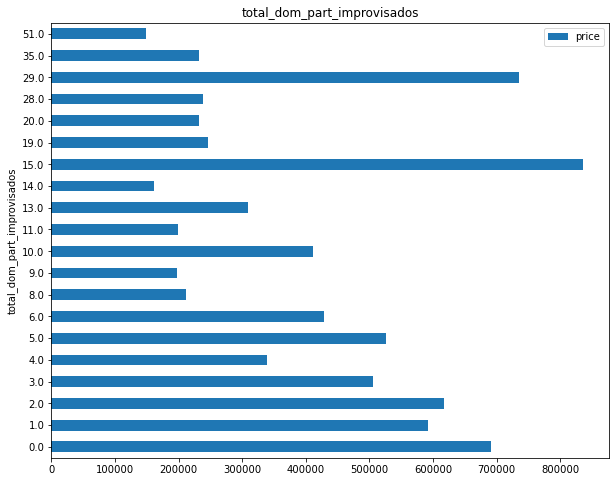

In [205]:
col = "total_dom_part_improvisados"

df_train[[col, target_col]].groupby(col).mean().plot(kind="barh", figsize=(10, 8), title=col);

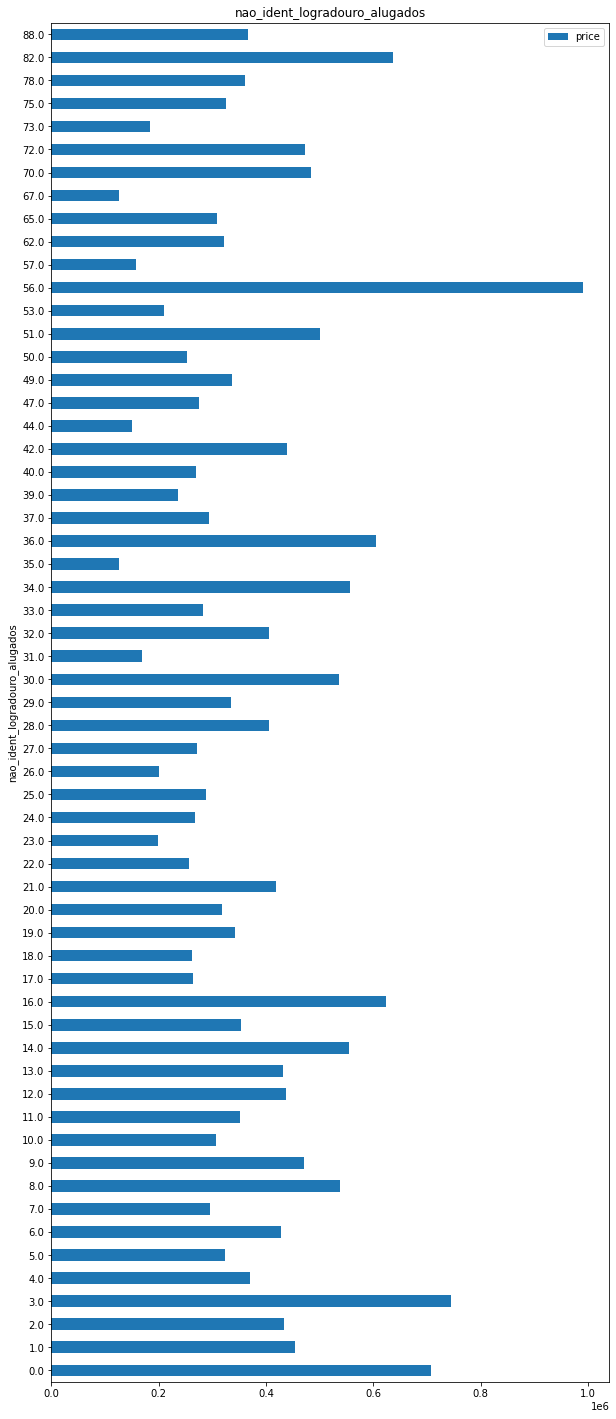

In [206]:
col = "nao_ident_logradouro_alugados"

df_train[[col, target_col]].groupby(col).mean().plot(kind="barh", figsize=(10, 25), title=col);

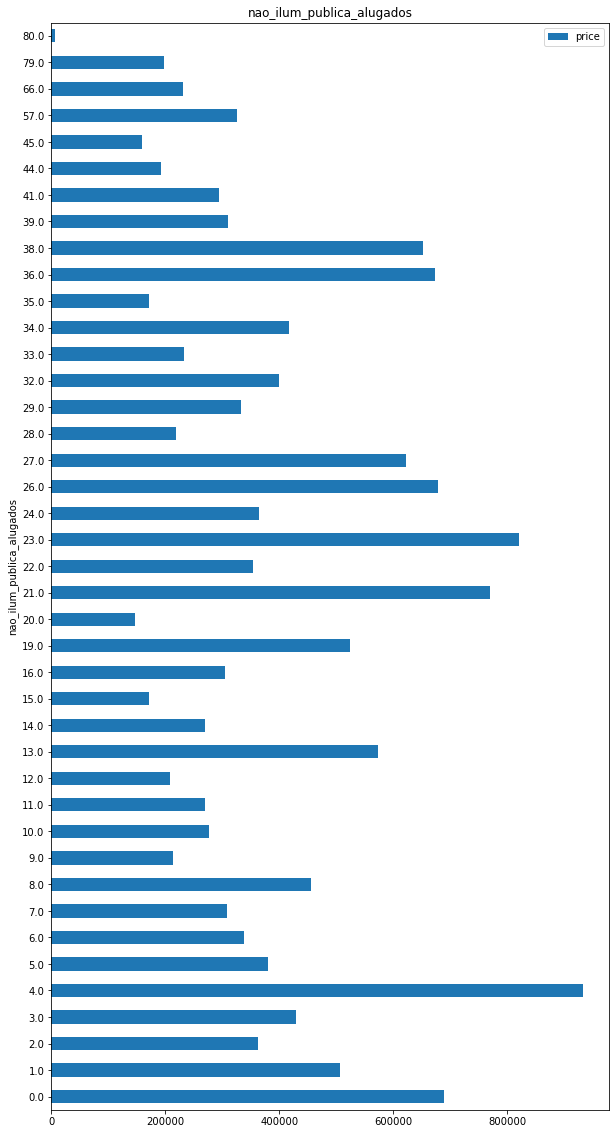

In [207]:
col = "nao_ilum_publica_alugados"

df_train[[col, target_col]].groupby(col).mean().plot(kind="barh", figsize=(10, 20), title=col);

## Feature importance

In [208]:
invalid_cols = ["id", "has_elevator", "rural_urbano", "geohash_4", "geohash_3", "geohash"]

In [209]:
X = prep_modeling(df_train, invalid_cols)

In [210]:
y = X[target_col].values
X = X.drop(columns=[target_col]+all_salary, errors="ignore")

In [211]:
model = RandomForestRegressor()
model.fit(X, y)

importance = model.feature_importances_
features = X.columns.tolist()

In [212]:
feature_importance = pd.DataFrame({"importance": importance}, index=features)
feature_importance.sort_values(by="importance", ascending=False)

importance
usableAreas                      0.486806
businessType                     0.111417
usableAreas_bins                 0.077924
geohash_5                        0.070619
monthlyCondoFee                  0.051325
parkingSpaces                    0.034461
bathrooms                        0.022958
wealthy_salary_rate              0.021244
totalAreas                       0.015011
renda_nom_dom_sem_rendimento     0.012279
ident_logradouro_alugados        0.010054
yearlyIptu                       0.009755
geohash_6                        0.009604
suites                           0.009500
wealthy_salary_count             0.007775
ident_logradouro_proprios        0.006972
ilum_publica_proprios            0.006749
ilum_publica_alugados            0.006187
renda_nom_dom_part_perm          0.005791
renda_nom_dom_part               0.005062
bedrooms                         0.003608
wealthy_rate_neighborhood        0.003319
has_grill                        0.001512
total_dom_part_improvisados      0.001149
has_garden                       0.001091
has_playground                   0.000779
has_pool                         0.000739
has_toilet                       0.000689
has_closet                       0.000627
has_balcony                      0.000619
has_partyRoom                    0.000597
has_gym                          0.000588
nao_ident_logradouro_proprios    0.000520
has_games                        0.000507
has_furnitures                   0.000456
renda_nom_dom_part_imp           0.000366
has_lobby                        0.000345
nao_ilum_publica_proprios        0.000343
publicationType                  0.000235
nao_ident_logradouro_alugados    0.000215
nao_ilum_publica_alugados        0.000203

The graph below was developed with JavaScript, if you can't see it here, you can have an image on **docs/images/feature_importance.png**

In [213]:
px.bar(feature_importance.sort_values(by="importance"),
       x="importance", title="Feature importance", orientation='h', height=1024)

## Target feature stats

In [17]:
y_stats = pd.DataFrame(y).describe()
y_stats.columns = ["stats"]
y_stats["stats"] = y_stats["stats"].astype(int)
y_stats

stats
count     72241
mean     678399
std     1015756
min         106
25%      224000
50%      409500
75%      770000
max    74200000

The graph below was developed with JavaScript, if you can't see it here, you can have an image on **docs/images/price_variance.png**

In [18]:
px.histogram(pd.DataFrame(y, columns=["price"]), nbins=500)

## Conclusions

We have a lot of features that isn't most importante to the modeling,probably, we need to go back to processing and spend more time adjusting the features of the "Description" and the 2010 IBGE Census Data.

About **geohash** we saw that `geohash_5` got a higher importance than `geohash_6`. Perhaps we'll exclude `geohash_6` on the modeling step.